<a href="https://colab.research.google.com/github/rukaiyafahmida/Object-Background-Blurring/blob/main/Object_Blurring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from io import BytesIO
import tarfile
import tempfile
import pandas as pd
import cv2
from google.colab import files
from six.moves import urllib
from copy import deepcopy
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import Image as IMG
import tensorflow as tf 



In [ ]:
class DeepLabModel(object):
  
  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  
  INPUT_SIZE = 512
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  #loading pretrained deeplab model
  def __init__(self, tarball_path):
    self.graph = tf.Graph()

    graph_def = None
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)


#resizing and masking 
  def run(self, image):

    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    print(width, height)
    print("Resize Ratio - {}".format(resize_ratio))
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    print(target_size)
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_segment_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    segment_map = batch_segment_map[0]
    return resized_image, segment_map

#helper functions for assigning color to obj segmentation 
def create_label_colormap():
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]

#helper func for visualizing segmentation and overlaying
def visualize_segmentation(image, segment_map):
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

#detected masked
  plt.subplot(grid_spec[1])
  segment_image = label_to_color_image(segment_map).astype(np.uint8)
  plt.imshow(segment_image)
  plt.axis('off')
  plt.title('segmentation map')

#overlaying
  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(segment_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

#showing found labels
  unique_labels = np.unique(segment_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABELS[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()
  return unique_labels


LABELS = np.asarray([
    'background', 'airplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv','apple','stop sign','street sign','traffic light'
])

FULL_LABEL_MAP = np.arange(len(LABELS)).reshape(len(LABELS), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)



In [ ]:
# Downloading the mobilenetv2 model form tensorflow site.
MODEL_NAME = 'mobilenetv2_coco_voctrainaug'

_DOWNLOAD_URL = 'http://download.tensorflow.org/models/deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz'
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
urllib.request.urlretrieve(_DOWNLOAD_URL,
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully')


model loaded successfully


In [ ]:
#visualise segmentation
def run_visualization():
  try:
    original_img = Image.open(IMAGE_NAME)
  except IOError:
    print('Cannot retrieve image.')
    return

  print('Running image on deeplab')
  resized_img, seg_map = MODEL.run(original_img)
  obj=visualize_segmentation(resized_img, seg_map)
  return resized_img, seg_map,obj

In [ ]:
upload = files.upload()


In [ ]:
pic= list(upload.keys())


Running image on deeplab
290 174
Resize Ratio - 1.7655172413793103
(512, 307)


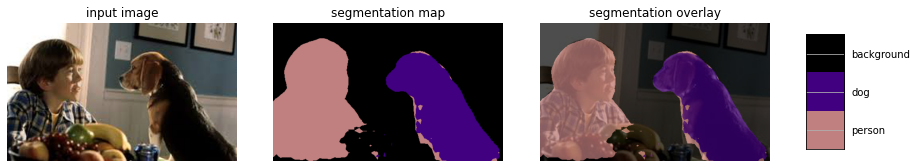

In [ ]:
IMAGE_NAME = pic[0] 
resized_im, seg_map, obj = run_visualization() 

In [ ]:
segment= input('Enter the object name: ') 

Enter the object name: person


In [ ]:
obj_list=LABELS.tolist()

In [ ]:
seg_index = obj_list.index(segment)

In [ ]:
print(type(resized_im))
numpy_img = np.array(resized_im) 

<class 'PIL.Image.Image'>


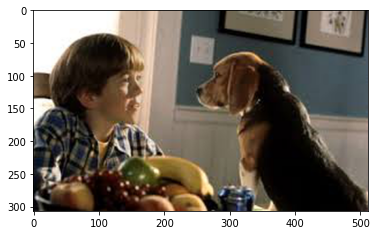

In [ ]:
plt.imshow(numpy_img)

In [ ]:
#creating masks
obj_mapping = deepcopy(numpy_img)  
obj_mapping[seg_map != seg_index] = 0        
obj_mapping[seg_map == seg_index] = 255     


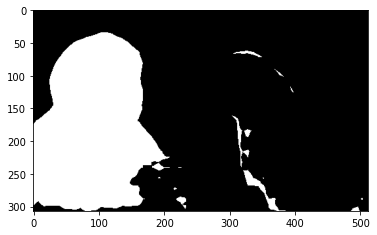

In [ ]:
plt.imshow(obj_mapping) 

In [ ]:
np.unique(obj_mapping) 

array([  0, 255], dtype=uint8)

In [ ]:
original_img = Image.open(IMAGE_NAME) 
original_img = np.array(original_img)

In [ ]:
original_img.shape

(174, 290, 3)

In [ ]:
#Resizing the mapped image
mapping_resized = cv2.resize(obj_mapping, 
                             (original_img.shape[1],
                              original_img.shape[0]),
                             Image.ANTIALIAS)

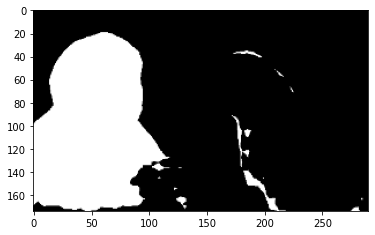

In [ ]:
plt.imshow(mapping_resized)

In [ ]:
mapping_resized.shape

(174, 290, 3)

Binarization Thresholding

In [ ]:
#Converting mapped img to gray
gray = cv2.cvtColor(mapping_resized, cv2.COLOR_BGR2GRAY)

#Apply Gaussian Blur to smooth and fill in gaps
blurred = cv2.GaussianBlur(gray,(25,25),0)

#Binarization based on Otsu's
ret3,binary_img = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) 

In [ ]:
binary_img.ndim

2

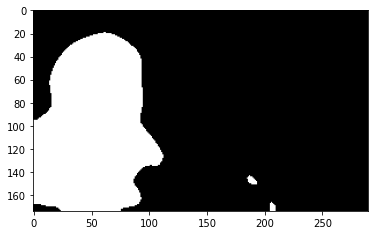

In [ ]:
plt.imshow(binary_img, cmap="gray")

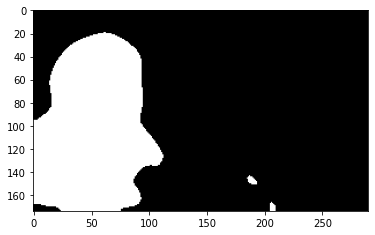

In [ ]:
# Converting gray to RGB 
mapping = cv2.cvtColor(binary_img, cv2.COLOR_GRAY2RGB) 
plt.imshow(mapping) 

In [ ]:
mapping.ndim

3

In [ ]:
blurred_original_image = cv2.GaussianBlur(original_img, 
                                          (93,93), 
                                          0)

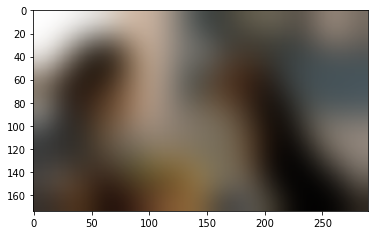

In [ ]:
plt.imshow(blurred_original_image)

In [ ]:
layered_image = np.where(mapping != (0,0,0), 
                         original_img, 
                         blurred_original_image)


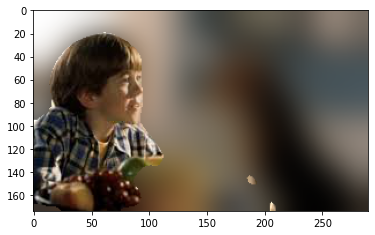

In [ ]:
plt.imshow(layered_image) 

In [ ]:
out_img_rgb = cv2.cvtColor(layered_image, cv2.COLOR_BGR2RGB)
cv2.imwrite("BLurred_Output_Image.jpg", out_img_rgb)

True

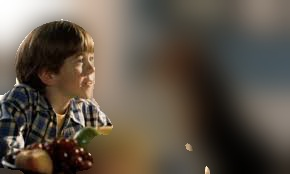

In [ ]:
IMG("BLurred_Output_Image.jpg")